In [1]:
import context
from rateslib import *
from rateslib.fx_volatility import FXDeltaVolSmile

In [ ]:
eureur = Curve(
    {dt(2023, 3, 16): 1.0, dt(2023, 9, 16): 0.9851909811629752}, calendar="tgt", id="eureur"
)
usdusd = Curve(
    {dt(2023, 3, 16): 1.0, dt(2023, 9, 16): 0.976009366603271}, calendar="nyc", id="usdusd"
)
eurusd = Curve(
    {dt(2023, 3, 16): 1.0, dt(2023, 9, 16): 0.987092591908283}, id="eurusd"
)
fxr = FXRates({"eurusd": 1.0615}, settlement=dt(2023, 3, 20))
fxf = FXForwards(
    fx_curves={"eureur": eureur, "eurusd": eurusd, "usdusd": usdusd},
    fx_rates=fxr
)

In [ ]:
fxvs = FXDeltaVolSmile(
    nodes={0.25: 8.9, 0.5: 7.9, 0.75: 10.15},
    eval_date=dt(2023, 3, 16),
    expiry=dt(2023, 6, 16),
    delta_type="forward",
    id="fxvs",
)

In [ ]:
fxc = FXCall(
    pair="eurusd",
    expiry=dt(2023, 6, 16),
    notional=20e6,
    strike=1.101,
    payment_lag=dt(2023, 3, 20),
    delivery_lag=2,
    calendar="tgt",
    modifier="mf",
    premium_ccy="usd",
    eval_date=NoInput(0),
    option_fixing=NoInput(0),
    premium=NoInput(0),
    delta_type="forward",
    curves=[None, fxf.curve("eur", "usd"), None, fxf.curve("usd","usd")],
    spec=NoInput(0),
)

In [ ]:
fxc2 = FXCall(
    pair="eurusd",
    expiry=dt(2023, 6, 16),
    notional=20e6,
    strike=1.101,
    payment_lag=dt(2023, 3, 20),
    delivery_lag=2,
    calendar="tgt",
    modifier="mf",
    premium_ccy="usd",
    eval_date=NoInput(0),
    option_fixing=NoInput(0),
    premium=float(fxc.rate(vol=8.9, fx=fxf)*20e6/10e3),
    delta_type="forward",
    curves=[None, fxf.curve("eur", "usd"), None, fxf.curve("usd","usd")],
    spec=NoInput(0),
)

In [ ]:
g0 = fxc2.analytic_greeks(vol=8.9, fx=fxf)
g0

# Wyestrup

In [ ]:
fxr = FXRates({"eurusd": 1.3088, "usdjpy": 90.68}, settlement=dt(2009, 1, 22))
eureur = Curve(id="eur", nodes={dt(2009, 1, 20): 1.0, dt(2009, 2, 25): 1.0})
usdusd = Curve(id="usd", nodes={dt(2009, 1, 20): 1.0, dt(2009, 2, 25): 1.0})
jpyjpy = Curve(id="jpy", nodes={dt(2009, 1, 20): 1.0, dt(2009, 2, 25): 1.0})
fxf = FXForwards(
    fx_rates=fxr,
    fx_curves={
        "eureur": eureur, "eurusd": eureur,
        "usdusd": usdusd,
        "jpyjpy": jpyjpy, "jpyusd": jpyjpy,
    }
)
solver = Solver(
    id="rates",
    curves=[eureur, usdusd, jpyjpy],
    instruments=[
        IRS(dt(2009, 1, 22), "1M", spec="eur_irs", curves=eureur),
        IRS(dt(2009, 1, 22), "1M", spec="usd_irs", curves=usdusd),
        IRS(dt(2009, 1, 22), "1M", spec="usd_irs", curves=jpyjpy),
    ],
    s=[2.0113, 0.3525, 0.42875],
    instrument_labels=["eur_1m", "usd_1m", "jpy_1m"],
    fx=fxf,
)

In [ ]:
dvs = FXDeltaVolSmile(
    id="smile",
    nodes={0.25: 10.0, 0.50: 10.0, 0.75: 10.0},
    eval_date=dt(2009, 1, 20),
    expiry=dt(2009, 2, 20),
    delta_type="spot",
)
curves = [None, "eur", None, "usd"]
args = {
    "expiry": dt(2009, 2, 20), 
    "pair": "eurusd", 
    "curves": curves, 
    "delta_type": "spot",
    "vol": "smile"
} 
solver2 = Solver(
    id="vol_smile",
    pre_solvers=[solver],
    curves=[dvs],
    instruments=[
        FXStraddle(strike="atm_delta", **args),
        FXRiskReversal(strike=["-25d", "25d"], **args),
        FXBrokerFly(strike=["-25d", "atm_delta", "25d"], **args),
    ],
    instrument_labels=["atm", "25rr", "25fly"],
    s=[21.6215, -0.5, 0.7375],
    fx=fxf,
)

In [ ]:
dvs.plot()

In [ ]:
fxc = FXCall(strike=1.36, **args, notional=100e6, premium=139.262198*100e6/10e3, premium_ccy="usd")
fxc.rate(solver=solver2, metric="pips_or_%")

In [ ]:
fxc.npv(solver=solver2)

In [ ]:
fxc.delta(solver=solver2)

In [ ]:
fxc.gamma(solver=solver2)

In [ ]:
fxc.analytic_greeks(solver=solver2)

In [ ]:
dvs.plot()

In [ ]:
dvs2 = FXDeltaVolSmile(
    id="smile2",
    nodes={0.25: 1.0, 0.50: 1.0, 0.75: 1.0},
    eval_date=dt(2009, 1, 20),
    expiry=dt(2009, 2, 20),
    delta_type="forward",
)
args = {
    "expiry": dt(2009, 2, 20), 
    "pair": "eurusd", 
    "curves": [None, "eur", None, "usd"], 
    "delta_type": "spot",
    "vol": "smile2",
    "premium_ccy": "eur",
} 
solver2 = Solver(
    id="vol_smile",
    pre_solvers=[solver],
    curves=[dvs2],
    instruments=[
        FXStraddle(strike="atm_delta", **args),
        FXRiskReversal(strike=["-25d", "25d"], **args),
        FXStrangle(strike=["-25d", "25d"], **args),
    ],
    s=[21.6215, -0.5, 22.359],
    fx=fxf,
)

In [ ]:
dvs.plot(comparators=[dvs2], labels=["unajd.", "prem adj."])

In [ ]:
fxr = FXRates({"eurusd": 1.3088}, settlement=dt(2009, 1, 22))
eureur = Curve(id="eur", nodes={dt(2009, 1, 20): 1.0, dt(2009, 2, 25): 1.0})
usdusd = Curve(id="usd", nodes={dt(2009, 1, 20): 1.0, dt(2009, 2, 25): 1.0})
fxf = FXForwards(
    fx_rates=fxr,
    fx_curves={
        "eureur": eureur,
        "eurusd": eureur,
        "usdusd": usdusd,
    }
)
solver = Solver(
    id="rates",
    curves=[eureur, usdusd],
    instruments=[
        IRS(dt(2009, 1, 22), "1M", spec="eur_irs", curves=eureur),
        IRS(dt(2009, 1, 22), "1M", spec="usd_irs", curves=usdusd),
    ],
    s=[2.0113, 0.3525],
    instrument_labels=["eur_1m", "usd_1m"],
    fx=fxf,
)

In [1]:
import context
from rateslib import *
from rateslib.fx_volatility import FXDeltaVolSmile, FXDeltaVolSurface
import numpy as np

In [2]:
fxvs = FXDeltaVolSurface(
    expiries=[dt(2024, 6, 1), dt(2024, 7, 1), dt(2024, 8, 1)],
    delta_indexes=[0.25, 0.5, 0.75],
    eval_date=dt(2024, 5, 1),
    delta_type="forward",
    node_values=10.0 * np.eye(3,3),
)

In [3]:
fxvs.smiles

In [2]:
bus = get_calendar("bus")

In [7]:
import pandas as pd
fixings = pd.Series(
    data=2.0, 
    index=pd.date_range(start=dt(2022, 1, 1), end=dt(2022, 4, 1), freq=bus)
)

,0
2022-01-03 00:00:00,2.000000
2022-01-04 00:00:00,2.000000
2022-01-05 00:00:00,2.000000
2022-01-06 00:00:00,2.000000
2022-01-07 00:00:00,2.000000
2022-01-10 00:00:00,2.000000
2022-01-11 00:00:00,2.000000
2022-01-12 00:00:00,2.000000
2022-01-13 00:00:00,2.000000
2022-01-14 00:00:00,2.000000


# Easiest way

But very basic and not really what the object is designed for.

In [2]:
fx_curve = LineCurve(
    nodes={
        dt(2024, 5, 23): 1.06,
        dt(2024, 5, 30): 1.063,
        dt(2024, 6, 23): 1.064,
        dt(2024, 7, 23): 1.068,
    }
)

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x11e5ad010>])

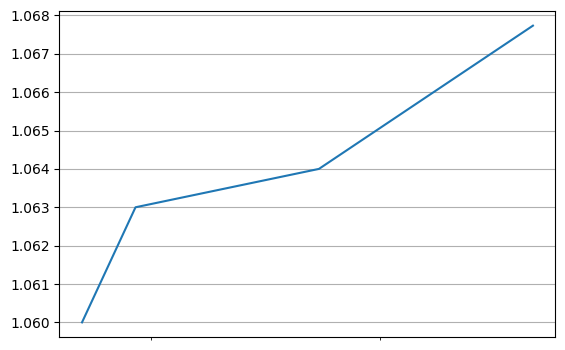

In [6]:
fx_curve.plot("1b")

# Using a Solver to Parametrise the Easy Curve

In [11]:
solver = Solver(
    curves=[fx_curve],
    instruments=[
        Value(dt(2024, 5, 30), curves=fx_curve),
        Value(dt(2024, 6, 23), curves=fx_curve),
        Value(dt(2024, 7, 23), curves=fx_curve),
    ],
    s=[1.065, 1.07, 1.095]
)

SUCCESS: `func_tol` reached after 8 iterations (levenberg_marquardt), `f_val`: 3.4069700029923517e-12, `time`: 0.0033s


(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x11ea60c90>])

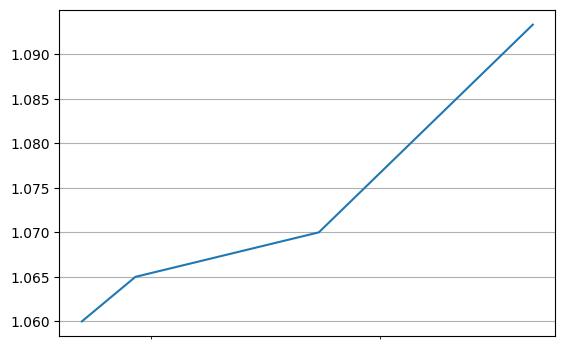

In [12]:
fx_curve.plot("1b")

# Getting Closer to the Proper Method

Creating FX curves without rates information, i.e. setting 
domestic and foreign rates to zero and relying on the FXSwaps

In [21]:
fxr = FXRates({"audusd": 0.620}, settlement=dt(2003, 4, 7))

In [22]:
fxr.rates_table()

,aud,usd
aud,1.000000,0.62
usd,1.612903,1.00


In [26]:
import math
aud = Curve({dt(2003, 4, 7): 1.0, dt(2005, 4, 7): math.exp(-0.05*2)}, id="aud")
usd = Curve({dt(2003, 4, 7): 1.0, dt(2005, 4, 7): math.exp(-0.07*2)}, id="usd")
fxf = FXForwards(
    fx_rates=fxr,
    fx_curves={"audaud": aud, "usdusd": usd, "audusd": aud}
)

In [24]:
solver = Solver(
    curves=[aud, usd],
    instruments=[
        Value(dt(2005, 4, 7), curves="aud", metric="cc_zero_rate", convention="30360"),
        Value(dt(2005, 4, 7), curves="usd", metric="cc_zero_rate", convention="30360"),
    ],
    s=[5.00, 7.00],
    fx=fxf,
)       

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 1.0610826305298004e-15, `time`: 0.0030s


In [27]:
fxf.rate("audusd", dt(2005, 4, 7))

<Dual: 0.645303, (fx_audusd), [1.0]>

In [28]:
1378 / 3000

0.4593333333333333

In [29]:
3421/3000

1.1403333333333334

In [30]:
2351/3000

0.7836666666666666

In [31]:
3138/3000

1.046

In [32]:
5425 / 3000

1.8083333333333333